Cleansing & Transforming  
Summary of steps:  

-Merge Weather attributes and Bike data
-Convert datetime columns from 'object' type to 'datetime' type  
-Add new column to identify the year (ie. 9999)  
-Add new column to identify the month (ie. 1 to 12)  
-Add new column to identify the hour (ie. 0 to 24)  
-Add new column to identify the time of day (ie. AM1, AM2, PM1, PM2)  


In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the Bike Data

In [2]:
df_bixi = pd.read_csv('../../Data/Raw/MTL_data/OD_2017.csv',low_memory=False)
df_stn = pd.read_csv('../../Data/Raw/MTL_data/Stations_2017.csv',low_memory=False)

# Procedures

In [ ]:
# def timeday(df):
#     result = []
#     for row in df:
#         if row <= 5:
#             #early morning 0:00 to 5:59
#             result.append('AM1')  
#         elif row <= 11:
#             #morning 6:00 to 11:59
#             result.append('AM2')
#         elif row <= 17:
#             #afternoon 12:00 to 17:59
#             result.append('PM1')
#         elif row <= 23:
#             #evening 18:00 to 11:59
#             result.append('PM2')
#         else:
#             result.append('')
#     return result

# Transform the data

In [3]:
df_bixi['end_station_code']=pd.to_numeric(df_bixi['end_station_code'],errors='coerce')
df_bixi.insert(5,'duration_min',df_bixi['duration_sec']/60)
df_bixi = df_bixi.drop('duration_sec',1)
#df = df.drop('column_name', 1)

In [4]:
#convert dates to date type
df_bixi['start_date'] = pd.to_datetime(df_bixi['start_date'])
df_bixi['end_date'] = pd.to_datetime(df_bixi['end_date'])
#df_bixi['end_station_code'] = pd.to_numeric(df_bixi['end_station_code'])

                                      


In [ ]:
print(df_bixi.isnull().sum())

In [5]:
#drop na rows
df_bixi=df_bixi.dropna() 

In [ ]:
# df_bixi.insert(1,'S_date',df_bixi['start_date'].dt.date)
# df_bixi.insert(2,'S_year',df_bixi['start_date'].dt.year)
# df_bixi.insert(3,'S_month',df_bixi['start_date'].dt.month)
# df_bixi.insert(4,'S_day',df_bixi['start_date'].dt.day)
# df_bixi.insert(5,'S_hour',df_bixi['start_date'].dt.hour)
# #determine time of day and add to dataframe
# df_timeday = timeday(df_bixi['S_hour'])
# df_bixi.insert(3,'S_time_day',df_timeday)

# df_bixi.insert(10,'E_date',df_bixi['end_date'].dt.date)
# df_bixi.insert(11,'E_year',df_bixi['end_date'].dt.year)
# df_bixi.insert(12,'E_month',df_bixi['end_date'].dt.month)
# df_bixi.insert(13,'E_day',df_bixi['end_date'].dt.day)
# df_bixi.insert(14,'E_hour',df_bixi['end_date'].dt.hour)
# #determine time of day and add to dataframe
# df_timeday = timeday(df_bixi['E_hour'])
#df_bixi.insert(6,'E_time_day',df_timeday)


In [ ]:
df_bixi.head()

In [6]:
#sort by start date
df_bixi = df_bixi.sort_values(by = ['start_date'])
#df_bixi.to_csv('../../Data/Processed/bixi.csv',index=False)

# Cleanse the data

In [7]:
df_Mtl = pd.read_csv('../../Data/Processed/Montreal.csv')


In [ ]:
print(df_Mtl.head(10))
print(df_bixi.head(10))
print(df_Mtl.dtypes)
print(df_bixi.dtypes)

In [30]:
df_Mtl['datetime'] = pd.to_datetime(df_Mtl['datetime'])
df_all = pd.merge_asof(df_bixi, df_Mtl, left_on = 'start_date', right_on = 'datetime', direction = 'nearest')    

In [ ]:
print(df_all.isnull().sum())

In [31]:
month_name = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
week_day = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
month_label = ['Apr','May','Jun','Jul','Aug','Sep']
weekday_label = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

df = df_all.start_date.dt.dayofweek.astype(str) + " - " + df_all.start_date.dt.dayofweek.map(week_day)
df_all.insert(2,'weekday',df)

df = df_all.start_date.dt.month.astype(str) + " - " + df_all.start_date.dt.month.map(month_name)
df_all.insert(3,'month',df)


In [35]:
df_all.to_csv('../../Data/Processed/bixiWeather.csv',index=False)

In [32]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,4018721.0,2.009360e+06,1.160105e+06,0.000000,1.004680e+06,2.009360e+06,3.014040e+06,4.018721e+06
start_station_code,4018721.0,6.324815e+03,3.758616e+02,5002.000000,6.105000e+03,6.203000e+03,6.389000e+03,1.000200e+04
end_station_code,4018721.0,6.319868e+03,3.832840e+02,5002.000000,6.092000e+03,6.195000e+03,6.394000e+03,1.000200e+04
duration_min,4018721.0,1.395751e+01,1.096191e+01,1.016667,6.366667e+00,1.116667e+01,1.868333e+01,1.199833e+02
is_member,4018721.0,7.992535e-01,4.005588e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
humidity,4018721.0,6.832245e+01,1.693025e+01,22.000000,5.500000e+01,6.800000e+01,8.200000e+01,1.000000e+02
pressure,4018721.0,1.014150e+03,6.029194e+00,990.000000,1.011000e+03,1.014000e+03,1.018000e+03,1.033000e+03
temp_celsius,4018721.0,1.841519e+01,5.574912e+00,-0.030000,1.468000e+01,1.897000e+01,2.260000e+01,3.168000e+01
wind_speed,4018721.0,3.860455e+00,2.178441e+00,0.000000,2.000000e+00,4.000000e+00,5.000000e+00,1.700000e+01
wind_direction,4018721.0,1.886021e+02,9.450672e+01,0.000000,1.300000e+02,2.200000e+02,2.500000e+02,3.600000e+02


# Data Visualization

Text(0.5,0,'Temperature (celsius)')

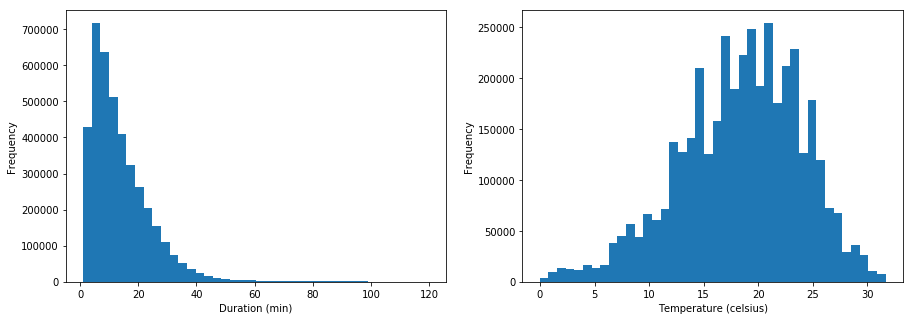

In [36]:

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

#Number of bixi rides by duration
df_all['duration_min'].plot.hist(bins=40)
plt.xlabel('Duration (min)')

#Number of bixi rides by temperature
plt.subplot(1,2,2)
(df_all['temp_celsius']).plot.hist(bins=40)
plt.xlabel('Temperature (celsius)')


Text(0.5,0,'Destination station')

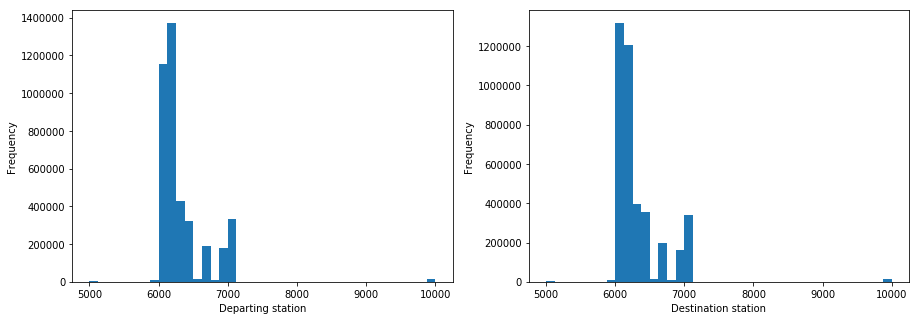

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

#Number of bixi rides by Departing Station
df_all['start_station_code'].plot.hist(bins=40)
plt.xlabel('Departing station')

#Number of bixi rides by Destination Station
plt.subplot(1,2,2)
df_all['end_station_code'].plot.hist(bins=40)
plt.xlabel('Destination station')

In [ ]:
# grouping the data by multiple column
df_all.groupby(by=['is_member', 'month'])['duration_min'].count().round()

# Bike Usage

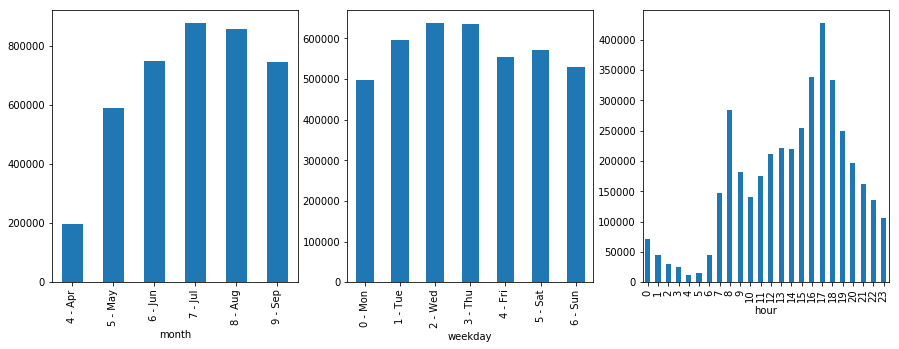

In [38]:

# df_all['weekday'] = df_all.start_date.dt.dayofweek
# df_all['weekday_abbr'] = df_all.start_date.dt.dayofweek.map(week_day)
df_all['hour'] = df_all.start_date.dt.hour
# df_all['month'] = df_all.start_date.dt.month
# df_all['month_abbr'] = df_all.start_date.dt.month.map(month_name)
#df_all['daynum'] = df_all.start_date.dt.dayofyear

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
df_all.groupby('month').count()['duration_min'].plot(kind='bar', color='#1f77b4')

plt.subplot(1,3,2)
df_all.groupby('weekday').count()['duration_min'].plot(kind='bar', color='#1f77b4')

plt.subplot(1,3,3)
df_all.groupby('hour').count()['duration_min'].plot(kind='bar', color='#1f77b4')

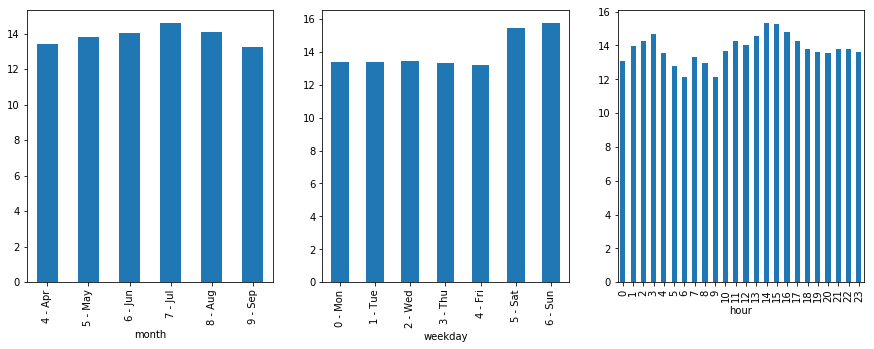

In [39]:
#Average

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
df_all.groupby('month').mean()['duration_min'].plot(kind='bar', color='#1f77b4')

plt.subplot(1,3,2)
df_all.groupby('weekday').mean()['duration_min'].plot(kind='bar', color='#1f77b4')

plt.subplot(1,3,3)
df_all.groupby('hour').mean()['duration_min'].plot(kind='bar', color='#1f77b4')



In [40]:
# #pivot table a dataframe
# df_all.pivot_table(index='zipcode', columns='bedrooms', values='price', aggfunc=np.mean).round()

In [41]:
df_pivot = df_all.pivot_table(columns='hour',index='weekday', aggfunc=np.count_nonzero)['duration_min'];

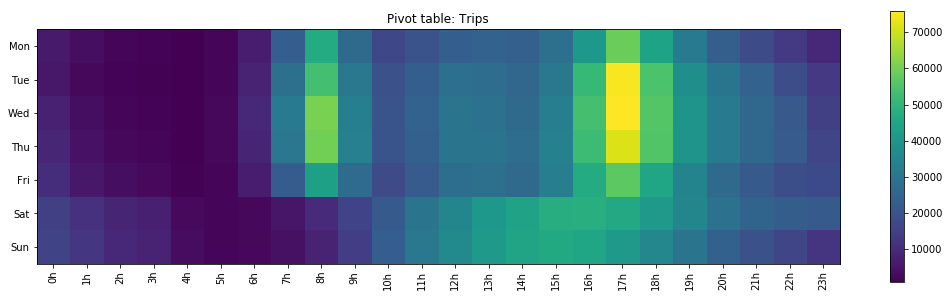

In [42]:
plt.figure(figsize=(18,5))
plt.title('Pivot table: Trips')
plt.imshow(df_pivot,interpolation='none')

hours = range(24)
hour_label = map(lambda x: str(x)+'h',hours)
weekdays = range(7)

plt.xticks(hours,hour_label,rotation=90)
plt.yticks(weekdays,weekday_label)
plt.colorbar()


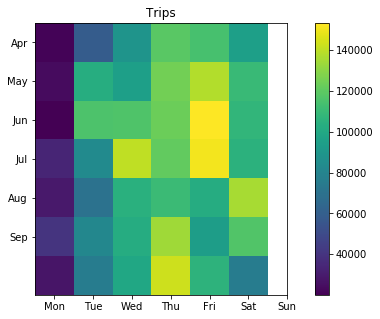

In [43]:
df_pivot2 = df_all.pivot_table(columns='month',index='weekday', aggfunc=np.count_nonzero)['duration_min'];

# Heatmap
plt.figure(figsize=(10,5))
plt.title('Trips')
plt.imshow(df_pivot2,interpolation='none')

months = range(6)
weekdays = range(7)

plt.xticks(weekdays,weekday_label)
plt.yticks(months,month_label)
plt.colorbar()


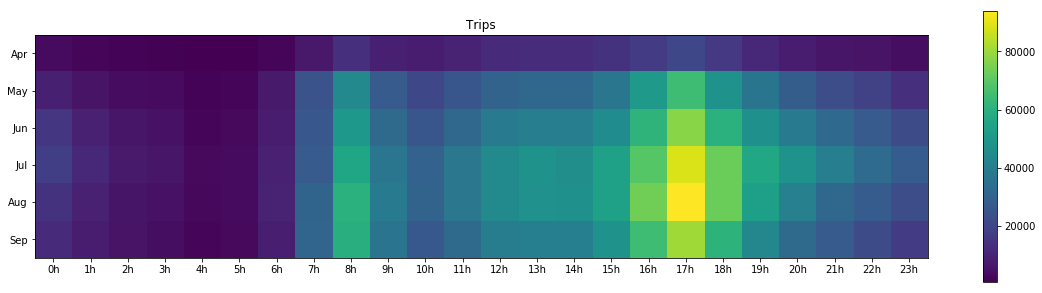

In [46]:
df_pivot3 = df_all.pivot_table(columns='hour',index='month', aggfunc=np.count_nonzero)['duration_min']

plt.figure(figsize=(20,5))
plt.title('Trips')
plt.imshow(df_pivot3,interpolation='none')

months = range(6)
hours = range(24)
hour_label = map(lambda x: str(x)+'h',hours)

plt.xticks(hours,hour_label)
plt.yticks(months,month_label)
plt.colorbar()

In [47]:
df_start = df_all.groupby('start_station_code').count()['duration_min'].to_frame();
df_top = df_start.sort_values(by = ['duration_min'], ascending=False);


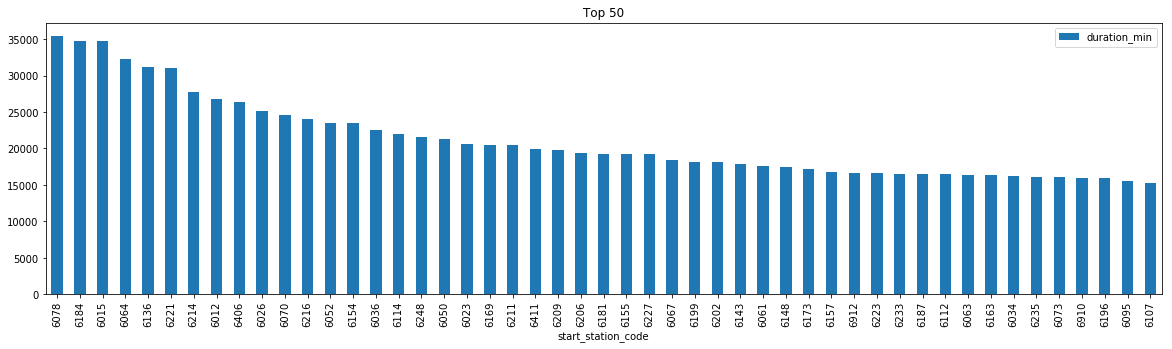

In [48]:
#Top 50 Departing stations
df_top[1:50].plot(kind='bar', color='#1f77b4', figsize=(20,5));
plt.title('Top 50');

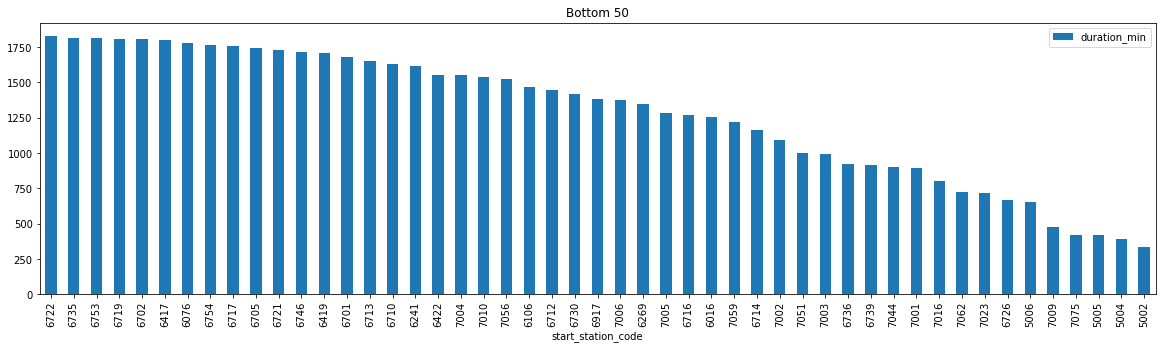

In [49]:
#Bottom 50 Departing stations
df_top[-50:-1].plot(kind='bar', color='#1f77b4', figsize=(20,5));
plt.title('Bottom 50');

Text(0,0.5,'Trips')

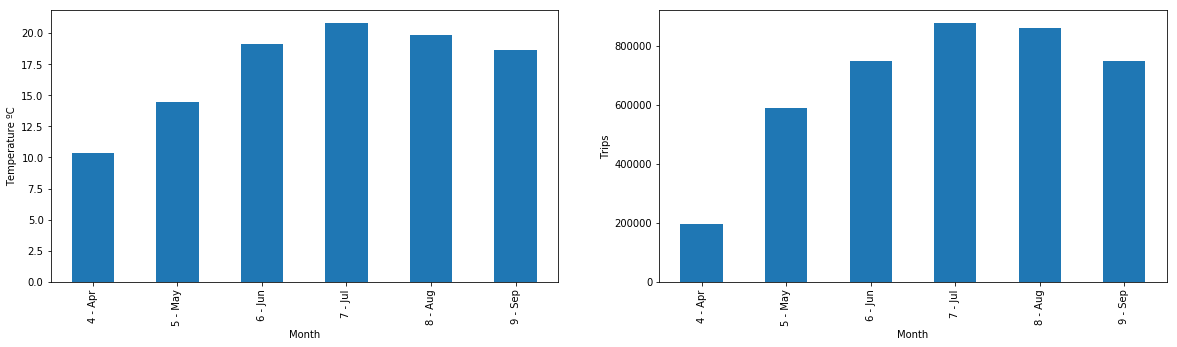

In [50]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_all.groupby('month').mean()['temp_celsius'].plot(kind='bar',color='#1f77b4')
plt.ylabel('Temperature ºC')
plt.xlabel('Month')

plt.subplot(1,2,2)
df_all.groupby('month').count()['temp_celsius'].plot(kind='bar',color='#1f77b4')
plt.xlabel('Month')
plt.ylabel('Trips')

7 - Jul    877340
8 - Aug    859474
6 - Jun    748080
9 - Sep    747648
5 - May    589852
4 - Apr    196327
Name: month, dtype: int64


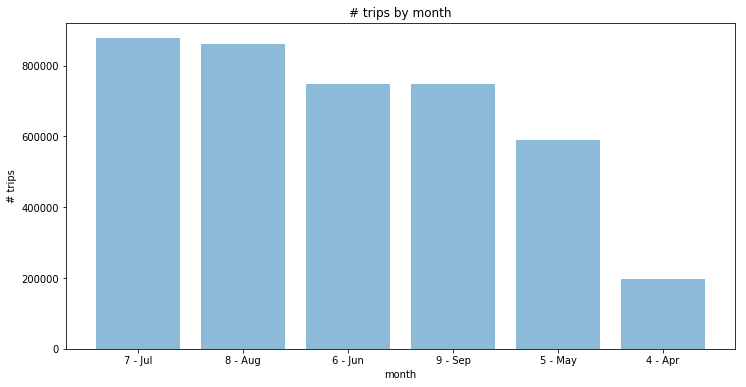

In [51]:
print(df_all['month'].value_counts())

# Bar Chart
plt.figure(figsize=(12,6))
plt.title('# trips by month')
plt.xlabel('month')
plt.ylabel('# trips')

labels = df_all['month'].value_counts().index
values = df_all['month'].value_counts().values

y_pos = range(len(labels))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.show()
#df_all['weekday_abbr'] = df_all.start_date.dt.dayofweek.map(week_day)
#df_all['month_abbr'] = df_all.start_date.dt.month.map(month_name)

In [52]:
print(df_all.dtypes)

Unnamed: 0                     int64
start_date            datetime64[ns]
weekday                       object
month                         object
start_station_code             int64
end_date              datetime64[ns]
end_station_code             float64
duration_min                 float64
is_member                      int64
datetime              datetime64[ns]
humidity                     float64
pressure                     float64
temp_celsius                 float64
description                   object
wind_speed                   float64
wind_direction               float64
hour                           int64
dtype: object


In [54]:
df= df_all;
df['weekday'] = df.start_date.dt.dayofweek
df['hour'] = df.start_date.dt.hour
df['num_week'] = df.start_date.dt.weekofyear
df = df.drop(['start_date','start_station_code', 'end_date', 'end_station_code', 'duration_min', 'is_member'], axis=1)

df_group = df.groupby(['num_week','weekday', 'hour']).agg('first')
column = df.groupby(['num_week','weekday', 'hour']).count()['description']

df_group['num_trips']= column
df_group=df_group.reset_index(level=[0,1,2])

df_group.head()


,num_week,weekday,hour,Unnamed: 0,month,datetime,humidity,pressure,temp_celsius,description,wind_speed,wind_direction,num_trips
0,15,5,0,0,4 - Apr,2017-04-15 00:00:00,22.0,1027.0,13.00,few clouds,4.0,260.0,144
1,15,5,1,144,4 - Apr,2017-04-15 01:00:00,34.0,1027.0,10.67,few clouds,3.0,240.0,76
2,15,5,2,226,4 - Apr,2017-04-15 02:00:00,37.0,1027.0,10.00,few clouds,3.0,220.0,39
3,15,5,3,280,4 - Apr,2017-04-15 03:00:00,42.0,1027.0,8.30,few clouds,3.0,210.0,40
4,15,5,4,241,4 - Apr,2017-04-15 04:00:00,56.0,1027.0,6.00,few clouds,3.0,210.0,12


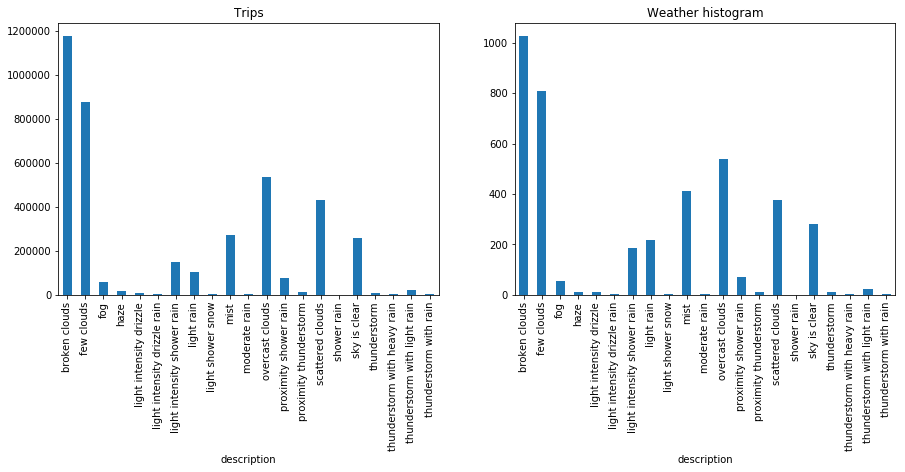

In [55]:
plt.figure(figsize=(15,5));
plt.subplot(1,2,1);
df_all.groupby('description').count()['duration_min'].plot(kind='bar',color='#1f77b4');
plt.title("Trips");


plt.subplot(1,2,2);
df_group.groupby('description').count()['temp_celsius'].plot(kind='bar',color='#1f77b4');
plt.title("Weather histogram");
#plt.tight_layout();

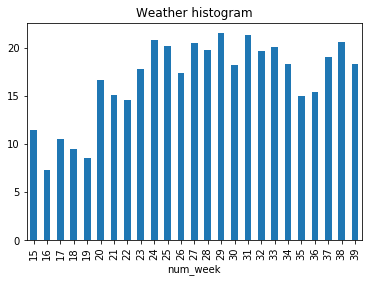

In [56]:
#plt.subplot(1,2,2);
df_group.groupby('num_week').mean()['temp_celsius'].plot(kind='bar',color='#1f77b4');
#df_group.groupby('num_week').mean()['wind_speed'].plot(kind='bar',color='#1f77b4');
plt.title("Weather histogram");
#plt.tight_layout();

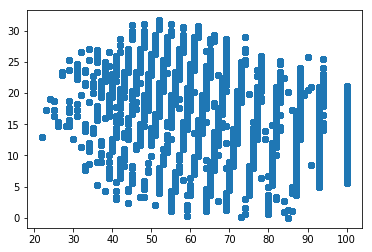

In [57]:
# Scatter plot
plt.plot(df_all['humidity'],df_all['temp_celsius'], 'o')
plt.show()

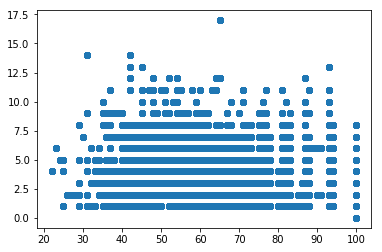

In [58]:
# Scatter plot
plt.plot(df_all['humidity'],df_all['wind_speed'], 'o')
plt.show()

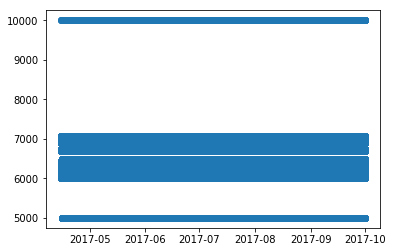

In [59]:
# Scatter plot
plt.plot(df_all['start_date'],df_all['start_station_code'], 'o')
plt.show()

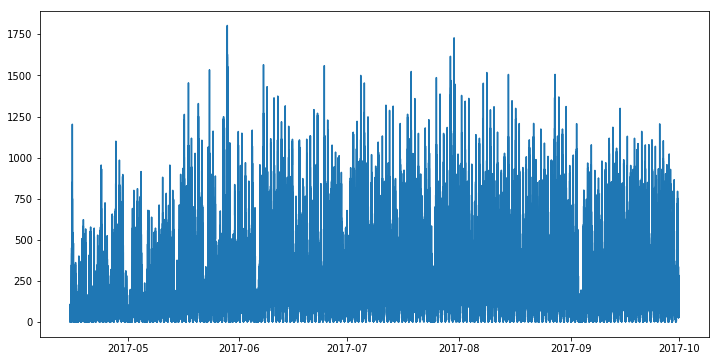

In [60]:
# Line chart
plt.figure(figsize=(12,6))
df_group = df_all.groupby(by='start_date')['duration_min'].sum()
plt.plot(df_group.index, df_group.values, '-')
plt.show()

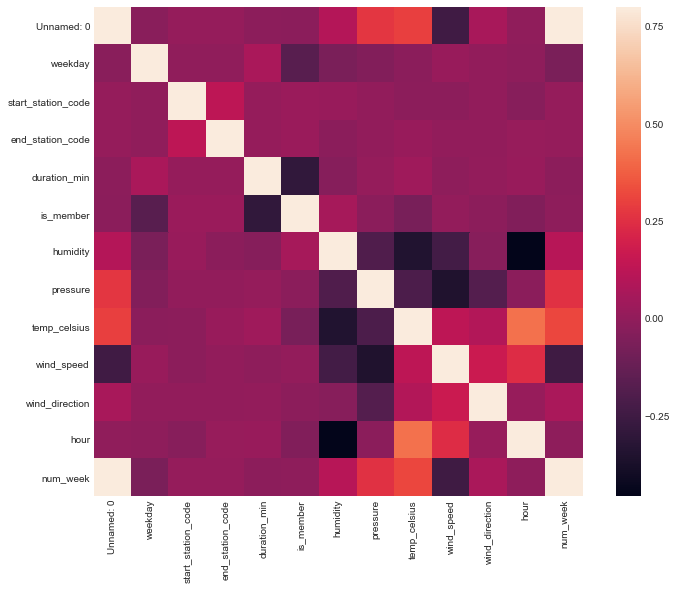

In [61]:
# the more advanced python visualization library
import seaborn as sns

# apply style to all the charts
sns.set_style('whitegrid')


# heatmap
corrmat = df_all.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()